<center style="font-weight:bold;font-size:20px">wbenbihi/hourglasstensorlfow: Stacked Hourglass Network for Human Pose Estimation</center>

<center style="font-weight:bold;font-size:20px">Training</center>

# Setup

## Imports

In [ ]:
import os
import sys
sys.path.append(os.path.join('..'))

In [ ]:
from config import CFG
import yaml
import pandas as pd
import tensorflow as tf
from src.dataset.functions import *

## Global Variables

In [ ]:
ROOT_FOLDER = CFG.ROOT_FOLDER
DATA_FOLDER = 'data'
IMAGE_FOLDER = 'images'
LABELS_FILE = "MPII_DATASET_LABELS.csv"

# Function definition

In [ ]:
def extract_coordinates_and_filenames(df: pd.DataFrame, config: dict):
    image_column = config['image_column']
    joint_format_regex = config["joint_column_format"].format(JOINTNUMBER="[0-9]*", IDVISIBILITY="(x|y)")
    filenames = (os.path.join(ROOT_FOLDER, config['data_folder']) + '/' + df.filter(regex=yaml_config.get('dataset').get('image_column'))).image.tolist()
    coordinates = df.filter(regex=joint_format_regex).values.reshape((-1, 16, 2))
    return filenames, coordinates

In [ ]:
def generate_io_dataset(filenames:list, coordinates, config: dict):
    dataset = tf.data.Dataset.from_tensor_slices(
        (filenames, coordinates)
    ).map(
        tf_parse_dataset
    ).map(
        lambda x, y: tf_preprocess(
            x,
            y, 
            config.get('data').get('input_size'),
            config.get('data').get('output_size')
        )
    )
    return dataset

In [ ]:
def generate

# Main Code

## Open YAML Config File

In [ ]:
with open(os.path.join(ROOT_FOLDER, 'config', 'hpeDefault.yml'), 'r') as f:
    yaml_config = yaml.load(f, Loader=yaml.FullLoader)

Let's open the DataFrame with the Dataset summary

In [ ]:
df = pd.read_csv(os.path.join(ROOT_FOLDER, yaml_config.get("dataset").get('summary_file')), sep=";")
train_df = df.query(f"{yaml_config.get('dataset').get('train_test_split')} == 1")
test_df = df.query(f"{yaml_config.get('dataset').get('train_test_split')} == 0")

In [ ]:
# We generate an array for 
train_filenames, train_coordinates = extract_coordinates_and_filenames(train_df, yaml_config.get('dataset'))
test_filenames, test_coordinates = extract_coordinates_and_filenames(test_df, yaml_config.get('dataset'))

In [ ]:
# We Instantiate our dataset
train_dataset = generate_io_dataset(train_filenames, train_coordinates, yaml_config)
test_dataset = generate_io_dataset(test_filenames, test_coordinates, yaml_config)

In [ ]:
test_dataset

In [ ]:
rand_tensor = tf.random.uniform(
    [], minval=-1*45, maxval=45, dtype=tf.dtypes.float32, seed=None, name=None
)

In [ ]:
rand_tensor

In [ ]:
@tf.function
def tf_random_rotation(images, heatmaps, rotation_range):
    rand = tf.random.uniform(
        [], minval=-1*rotation_range, maxval=rotation_range, dtype=tf.dtypes.float32, seed=None, name=None
    )
    rotated_images = tf.image.rotate(images, rand)
    rotated_heatmaps = tf.image.rotate(heatmaps, rand)
    return rotated_images, rotated_heatmaps

In [ ]:
from src.metrics.metrics import AmountCorrectKeypointsMetric

In [ ]:
import numpy as np

In [ ]:
from utils.argmax_funcs import argmax2D_without_batch

In [ ]:
a = np.random.randint(low=0, high=255, size=(3, 64, 64, 14))

In [ ]:
argmax = tf.argmax(tf.reshape(a, (3, 64*64, 14)), axis=-2)

In [ ]:
tf.transpose(tf.stack([argmax[-1] // 64, argmax[-1] % 64]))

In [ ]:
argmax

In [ ]:
col_indices = argmax // tf.cast(tf.transpose(64), tf.int64)
row_indices = argmax % tf.cast(tf.transpose(64), tf.int64)

In [ ]:
argmax

In [ ]:
tf.transpose(tf.stack([tf.reduce_mean(argmax // 64, axis=0), tf.reduce_mean(argmax % 64, axis=0)]))

In [ ]:
tf.stack([col_indices, row_indices])

In [ ]:
tf.reshape(tf.transpose(tf.stack([col_indices, row_indices]), [1, 2, 0]), (3*14, 2))

In [ ]:
argmax2D_without_batch(a, 3)

In [ ]:
tf.map_fn(argmax2D_without_batch, a)

In [ ]:
def tf_stacker(inputs, heatmaps, stacks):
    return inputs, tf.stack([heatmaps]*stacks, axis=0)

In [ ]:
u = train_dataset.map(tf_stacker)

In [ ]:
for tfsample in u.take(5):
    pass

In [ ]:
tfsample

The first element to check is the integer coefficient between input and output size to determine the number of downsizing.

In [ ]:
assert (CFG.default.HOURGLASS.inputsize / CFG.default.HOURGLASS.outputsize).is_integer(), 'InputSize is not divisible by OutputSize'
PREPROCESS_DOWNSIZING = int(CFG.default.HOURGLASS.inputsize / CFG.default.HOURGLASS.outputsize) -1

We then check if our input image mode is genuine to define the channel numbers

In [ ]:
assert CFG.default.HOURGLASS.inputmode in ["RGB", "BGR", "HSV", "HSL", "GRAY"], 'The input image mode is not recognized'
if CFG.default.HOURGLASS.inputmode in ["RGB", "BGR", "HSV", "HSL"]:
    CHANNELS = 3
elif CFG.default.HOURGLASS.inputmode in ["GRAY"]:
    CHANNELS = 1

In [ ]:
import numpy as np

In [ ]:
batch_img = np.random.randint(0, 255, (5, 256, 256, 3))
#batch_img = (batch_img / 255)

In [ ]:
batch_img.shape

In [ ]:
tf.reduce_mean(tf.cast(batch_img, tf.float64), axis=[-1, -2, -3], keepdims=True)

In [ ]:
@tf.function
def tf_normalize_minmax(tensor):
    # We assume a Tensor with NHWC format
    min_values = tf.reduce_min(tensor, axis=[-1, -2, -3], keepdims=True)
    max_values = tf.reduce_max(tensor, axis=[-1, -2, -3], keepdims=True)
    normalized_tensor = (tensor - min_values) / (max_values - min_values)
    return normalized_tensor

In [ ]:
@tf.function
def tf_normalize_stddev(tensor):
    # We assume a Tensor with NHWC format
    mean_values = tf.reduce_mean(tensor, axis=[-1, -2, -3], keepdims=True)
    std_values = tf.math.reduce_std(tensor, axis=[-1, -2, -3], keepdims=True)
    normalized_tensor = (tensor - mean_values) / tf.sqrt(std_values)
    return normalized_tensor

In [ ]:
from skimage import io

In [ ]:
tf.reduce_min(tf_normalize_minmax(batch_img))

In [ ]:
images =  [
    io.imread('../data/images/000041029.jpg'),
    io.imread('../data/images/000040154.jpg'),
    io.imread('../data/images/000050999.jpg'),
    io.imread('../data/images/000022704.jpg'),
    io.imread('../data/images/000015774.jpg'),
]
images = np.stack([tf.cast(tf_resize(tf_autopad(img), 256), tf.int64) for img in images], axis=0)

In [ ]:
y = tf_normalize_minmax(images)
z = tf_normalize_stddev(tf.cast(images, tf.float64))

In [ ]:
plt.imshow(z[1])

In [1]:
import os
import sys
sys.path.append(os.path.join('..'))
from src.run import Execution

In [2]:
exe = Execution('../config/hpeDefault.yml')

2020-12-12 19:05:56.961 | INFO     | src.run:__init__:18 - Launch Model Initialization...
2020-12-12 19:05:56.962 | SUCCESS  | src.run:__init__:23 - Launch Model in TRAINING type
2020-12-12 19:05:56.980 | SUCCESS  | src.run:__init__:26 - Loading YAML Configuartion: DONE
2020-12-12 19:05:58.814 | SUCCESS  | src.run:__init__:29 - Instantiate Datasets: DONE
2020-12-12 19:05:59.221 | SUCCESS  | src.run:__init__:51 - Instantiate Model Graph: DONE
2020-12-12 19:06:00.487 | SUCCESS  | src.run:__init__:61 - Building Model: DONE
2020-12-12 19:06:00.488 | SUCCESS  | src.run:__init__:65 - [TRAINING] Instantiate Model: DONE
2020-12-12 19:06:00.488 | SUCCESS  | src.run:__init__:68 - [TRAINING] Instantiate Optimizer: DONE
2020-12-12 19:06:00.489 | SUCCESS  | src.run:__init__:71 - [TRAINING] Instantiate Loss Functions: DONE
2020-12-12 19:06:00.511 | SUCCESS  | src.run:__init__:74 - [TRAINING] Instantiate Metrics: DONE
2020-12-12 19:06:00.512 | SUCCESS  | src.run:__init__:77 - [TRAINING] Callbacks: DO

In [3]:
exe.compile()

In [ ]:
import tensorflow as tf
import numpy as np
x_train = np.random.rand(1000, 256, 256, 3)
y_train = np.random.rand(1000, 2,64, 64, 16)
x_val = np.random.rand(200, 256, 256, 3)
y_val = np.random.rand(200, 2,64, 64, 16)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(16)
from dataclasses import dataclass
@dataclass
class FakeDataset:
    train = train_ds
    val = val_ds

fake_ds = FakeDataset()
exe.datasets = fake_ds

In [ ]:
exe.fit()

In [ ]:
exe.metrics

In [4]:
records = []
for i in exe.datasets.train.take(10):
    records.append(i)

In [7]:
import matplotlib.pyplot as plt

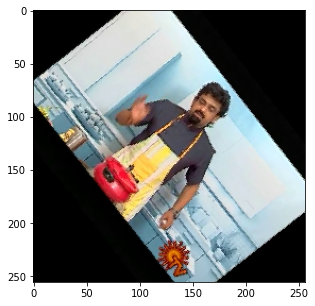

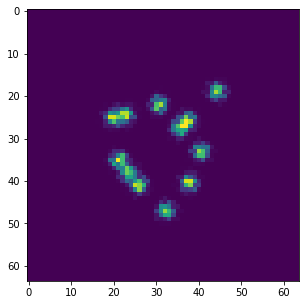

In [38]:
# Params
BATCH_NUMBER=1
IMAGE_NUMBER=0
# Viz
_ = plt.figure(figsize=(5, 5))
plt.imshow(records[BATCH_NUMBER][0][IMAGE_NUMBER])
_ = plt.figure(figsize=(5, 5))
plt.imshow(np.sum(records[BATCH_NUMBER][1][IMAGE_NUMBER][0], axis=-1))

In [15]:
import numpy as np

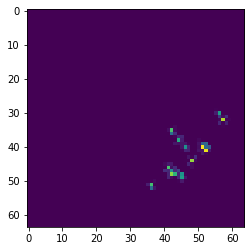

In [19]:
records[BATCH_NUMBER][1][IMAGE_NUMBER][0]

<tf.Tensor: shape=(64, 64, 16), dtype=float64, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 